In [11]:
import numpy as np
from collections import defaultdict
import sys,os
import matplotlib.pyplot as plt
import seaborn as sns
curr_path = os.path.abspath('')
parent_path = os.path.dirname(curr_path)
sys.path.append(parent_path)
import torch
import random
from rl.envs.racetrack import RacetrackEnv

## 1. Define Algorithm

In [3]:
class FisrtVisitMC:
    ''' On-Policy First-Visit MC Control
    '''
    def __init__(self,cfg):
        self.n_actions = cfg.n_actions
        self.epsilon = cfg.epsilon
        self.gamma = cfg.gamma 
        self.Q_table = defaultdict(lambda: np.zeros(cfg.n_actions))
        self.returns_sum = defaultdict(float) # sum of return
        self.returns_count = defaultdict(float)
        
    def sample_action(self,state):
        state = str(state)
        if state in self.Q_table.keys():
            best_action = np.argmax(self.Q_table[state])
            action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
            action_probs[best_action] += (1.0 - self.epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        else:
            action = np.random.randint(0,self.n_actions)
        return action
    
    def predict_action(self,state):
        state = str(state)
        if state in self.Q_table.keys():
            best_action = np.argmax(self.Q_table[state])
            action_probs = np.ones(self.n_actions, dtype=float) * self.epsilon / self.n_actions
            action_probs[best_action] += (1.0 - self.epsilon)
            action = np.argmax(self.Q_table[state])
        else:
            action = np.random.randint(0,self.n_actions)
        return action
    
    def update(self,one_ep_transition):
        # Find all (state, action) pairs we've visited in this one_ep_transition
        # Convert each state to a tuple so that we can use it as a dict key
        sa_in_episode = set([(str(x[0]), x[1]) for x in one_ep_transition])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            # Find the first occurence of the (state, action) pair in the one_ep_transition

            first_occurence_idx = next(i for i,x in enumerate(one_ep_transition)
                                       if str(x[0]) == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(self.gamma**i) for i,x in enumerate(one_ep_transition[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            self.returns_sum[sa_pair] += G
            self.returns_count[sa_pair] += 1.0
            self.Q_table[state][action] = self.returns_sum[sa_pair] / self.returns_count[sa_pair]

## 2. Define Training

In [5]:
def train(cfg,env,agent):
    print('start training！')
    print(f'environment:{cfg.env_name}, algorithm:{cfg.algo_name}, device:{cfg.device}')
    rewards = []  
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  
        one_ep_transition = []
        state = env.reset(seed=cfg.seed) 
        for _ in range(cfg.max_steps):
            action = agent.sample_action(state) 
            next_state, reward, terminated, info = env.step(action)  
            one_ep_transition.append((state, action, reward))
            agent.update(one_ep_transition) 
            state = next_state
            ep_reward += reward  
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"epoch：{i_ep+1}/{cfg.train_eps}，reward：{ep_reward:.1f}")
    print('end training！')
    return {"rewards":rewards}

def test(cfg,env,agent):
    print('start testing！')
    print(f'environment：{cfg.env_name}, algorithm：{cfg.algo_name}, device：{cfg.device}')
    rewards = []  
    for i_ep in range(cfg.test_eps):
        ep_reward = 0 
        state = env.reset(seed=cfg.seed)  
        for _ in range(cfg.max_steps):
            action = agent.predict_action(state) 
            next_state, reward, terminated, info = env.step(action)
            state = next_state 
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"epoch：{i_ep+1}/{cfg.test_eps}, reward：{ep_reward:.1f}")
    print('end testing！')
    return {"rewards":rewards}

## 3. Set Environment

In [10]:
def all_seed(env,seed = 1):
    ''' omnipotent seed for RL, attention the position of seed function, you'd better put it just following the env create function
    '''
    if seed == 0:
        return
    # print(f"seed = {seed}")
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
def env_agent_config(cfg):    
    env = RacetrackEnv() 
    all_seed(env,seed=cfg.seed) 
    n_states = env.observation_space.shape[0] 
    n_actions = env.action_space.n 
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    agent = FisrtVisitMC(cfg)
    return env,agent

## 4. Set Parameter

In [14]:
class Config:
    def __init__(self):
        self.env_name = 'Racetrack-v0' 
        self.algo_name = "FirstVisitMC" 
        self.train_eps = 400 
        self.test_eps = 20 
        self.max_steps = 200 # max steps each epoch
        self.epsilon = 0.1 # greedy
        self.gamma = 0.9 # discount
        self.lr = 0.5 # learning rate
        self.seed = 1 
        if torch.cuda.is_available(): # device
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
def smooth(data, weight=0.9):  
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure() 
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10) 
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

## 5. Start Training

In [13]:
cfg = Config() 
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)

C:\Users\ra-chen_saif_s1\Anaconda3\envs\rl_jl\lib\site-packages\gym\core.py:257: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


start training！
environment:Racetrack-v0, algorithm:FirstVisitMC, device:cuda
epoch：1/400，reward：-680.0
epoch：2/400，reward：-510.0
epoch：3/400，reward：-360.0
epoch：4/400，reward：-440.0
epoch：5/400，reward：-410.0
epoch：6/400，reward：-380.0
epoch：7/400，reward：-400.0
epoch：8/400，reward：-360.0
epoch：9/400，reward：-360.0
epoch：10/400，reward：-350.0
epoch：11/400，reward：-320.0
epoch：12/400，reward：-380.0
epoch：13/400，reward：-360.0
epoch：14/400，reward：-350.0
epoch：15/400，reward：-310.0
epoch：16/400，reward：-310.0
epoch：17/400，reward：-340.0
epoch：18/400，reward：-84.0
epoch：19/400，reward：-310.0
epoch：20/400，reward：-104.0
epoch：21/400，reward：-370.0
epoch：22/400，reward：-330.0
epoch：23/400，reward：-350.0
epoch：24/400，reward：-350.0
epoch：25/400，reward：-380.0
epoch：26/400，reward：-410.0
epoch：27/400，reward：-310.0
epoch：28/400，reward：-260.0
epoch：29/400，reward：-21.0
epoch：30/400，reward：-310.0
epoch：31/400，reward：-350.0
epoch：32/400，reward：-400.0
epoch：33/400，reward：-290.0
epoch：34/400，reward：-340.0
epoch：35/400，re

NameError: name 'plot_rewards' is not defined

start testing！
environment：Racetrack-v0, algorithm：FirstVisitMC, device：cuda
epoch：1/20, reward：-200.0
epoch：2/20, reward：-210.0
epoch：3/20, reward：-200.0
epoch：4/20, reward：-200.0
epoch：5/20, reward：-200.0
epoch：6/20, reward：-200.0
epoch：7/20, reward：-200.0
epoch：8/20, reward：-200.0
epoch：9/20, reward：-200.0
epoch：10/20, reward：2.0
epoch：11/20, reward：-200.0
epoch：12/20, reward：-200.0
epoch：13/20, reward：-200.0
epoch：14/20, reward：-200.0
epoch：15/20, reward：-200.0
epoch：16/20, reward：-200.0
epoch：17/20, reward：-200.0
epoch：18/20, reward：-200.0
epoch：19/20, reward：-200.0
epoch：20/20, reward：-200.0
end testing！


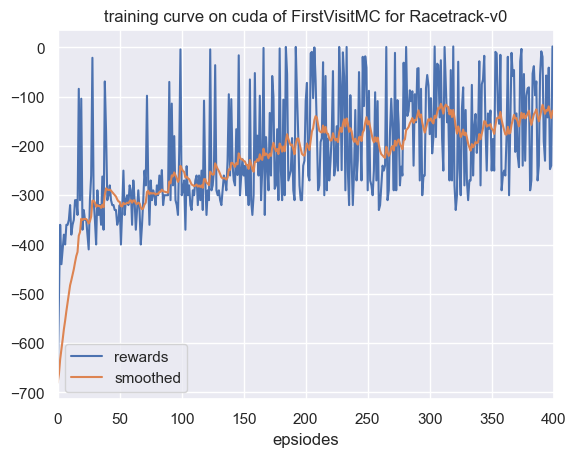

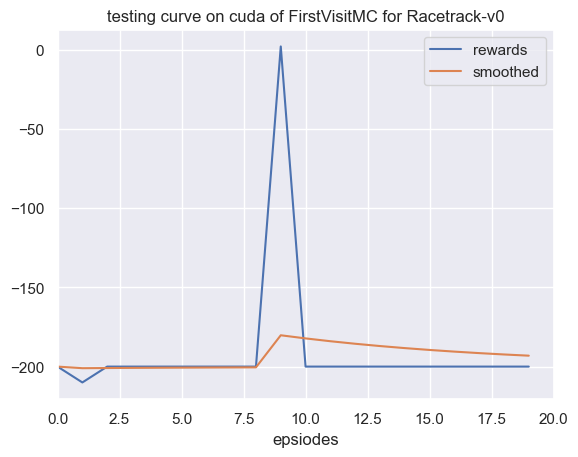

In [16]:
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  